# Pràctica 1:

Nom dels alumnes del grup:

# Anàlisi exploratòria de dades (EDA) & ús d'eines avançades de Python

L'**anàlisi exploratòria de dades** (EDA, per les seves sigles en anglès, *Exploratory Data Analysis*) és un procés crític en la ciència de les dades que implica **explorar, resumir i visualitzar** les dades per a entendre les seves característiques principals. L'objectiu principal de l'EDA és revelar patrons, tendències i anomalies a partir de les dades, sense fer suposicions massa específiques o construir models massa complexes.

Aquí teniu alguns dels elements més importants de l'anàlisi exploratòria de dades:

+ **Visualització de dades**: A través de gràfics i gràfiques, es representen les dades per a veure distribucions, tendències i relacions. Això pot incloure histogrames, gràfics de barres, diagrames de dispersió, gràfics de caixa, etc.

+ **Estadístiques descriptives**: Es calculen estadístiques com la mitjana, la mediana, la desviació estàndard i altres mesures resum per a descriure les característiques bàsiques de les variables.

+ **Detecció d'anomalies**: Es busca identificar valors atípics o anòmals que puguin indicar errors o situacions especials en les dades.

+ **Imputació de dades faltants**: Si les dades tenen buits o valors faltants, es pot decidir com omplir aquests buits de manera adequada.

+ **Exploració de relacions**: Es busquen correlacions i relacions entre les diferents variables de les dades per a identificar connexions i dependencies.

+ **Agrupació de dades**: Es divideixen les dades en subconjunts basats en certes característiques per a analitzar-les més detingudament.

+ **Transformació de dades**: Es poden aplicar transformacions a les dades per a fer-les més adequades per a anàlisi posterior, com l'estandardització o la normalització.

* **Selecció de característiques**: Si es treballa amb un conjunt de dades amb moltes variables, es pot realitzar una selecció de característiques per a reduir la complexitat i millorar l'eficiència de l'anàlisi.

Python ofereix una àmplia gamma d'eines i biblioteques per a realitzar l'anàlisi exploratòria de dades (EDA). Algunes de les biblioteques més populars i útils són les següents:

+ **NumPy**: NumPy és una biblioteca fonamental per a la computació científica en Python. Proporciona funcionalitats per a treballar amb matrius i vectors, la qual cosa és essencial per a l'anàlisi de dades.

+ **Pandas**: Pandas és una biblioteca molt popular per a l'anàlisi de dades que ofereix estructures de dades com DataFrame i Series, que faciliten la manipulació i anàlisi de dades tabulars. Podeu utilitzar Pandas per a carregar, netejar i explorar les dades.

+ **Matplotlib**: Matplotlib és una biblioteca per a la visualització de dades que us permet crear una àmplia gamma de gràfics i gràfiques personalitzades. És ideal per a crear histogrames, diagrames de dispersió, gràfics de barres i moltes altres representacions gràfiques.

+ **Scipy**: SciPy és una biblioteca que amplia les funcionalitats de NumPy i proporciona eines addicionals per a l'anàlisi científic, inclosos estadístics i mètodes d'optimització.

+ **Scikit-learn**: Si esteu interessats en l'aprenentatge automàtic, Scikit-learn és una biblioteca essencial que ofereix eines per a la classificació, regressió, agrupació i altres tasques d'aprenentatge automàtic. També conté eines per a la selecció de característiques.

+ **Seaborn**: Seaborn és una biblioteca de visualització de dades basada en Matplotlib que simplifica la creació de gràfics estadístics atractius i informatius. És especialment útil per a la visualització de relacions i tendències en les dades.

## 0. Objectiu de la pràctica

L'**objectiu d'aquesta pràctica** és aprendre com fer una exploració sobre un conjunt de dades real, que al final ens permeti obtenir la resposta a diverses preguntes.

En aquesta pràctica explorarem les dades dels trajectes dels **taxis grocs de la ciutat de Nova York** durant varios anys.

En finalitzar aquesta pràctica, haureu de ser capaços de respondre la pregunta següent de forma detallada:

- **Com va afectar la pandèmia de la Covid l'ús dels taxis a Nova York?**

Pere respondre aquesta pregunta tant genèrica, ho podem descomposar en preguntes més concretes:

- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on més/menys taxis s'agafen?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més?
- Etc.

### Instal·lació i importació de les llibreries necessàries

A més a més de les llibreries comentades, farem servir aquests mòduls de Python:

+ **PyArrow**: PyArrow és una biblioteca de Python que es fa servir per a l'intercanvi eficient de dades entre Python i altres llenguatges de programació, especialment C++ i Java. Aquesta biblioteca es desenvolupa com a part del projecte Apache Arrow, que és un projecte de codi obert dissenyat per a millorar el rendiment i la interoperabilitat de l'analítica de dades i les tecnologies relacionades. PyArrow permet la creació i la manipulació eficient de dades en forma de taules i columnes. PyArrow ofereix suport per a l'estrués similar a una taula de dades en altres llenguatges. Aquesta estructura de dades facilita l'organització i la manipulació de dades tabulars.

In [1]:
from platform import python_version
print(python_version())

3.11.9


In [2]:
! pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
import pyarrow.parquet as pq

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Descàrrega de dades

In [4]:
# Variables globals: els anys que estudiarem

YEARS = [2019, 2020, 2021]

In [5]:
# Descàrrega de les dades: Trip Record Data
# https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

# Aquesta cel·la triga uns quants minuts a executar-se

for year in YEARS:
    if not os.path.exists(f'data/{year}'):
        print("Descarregant:", year)
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in range(1, 13):
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

## 2. Neteja de dades

Per tal de tenir unes dades netes i útils, eliminarem totes aquells trajectes (files del conjunt de dades)  que continguin informació *corrupte*. Per exemple, cal verificar que no es dóna cap d'aquests casos:

- Presència de *missing data* (camps/columnes de les dades sense valor).
- L'hora de recollida és posterior a la finalització del trajecte.
- Hi ha viatges amb un nombre absurd de passatgers?
- Hi ha viatges massa llargs o massa curts?
- Hi ha pagaments negatius?
- Etc.

A més a més, hem de considerar aspectes concrets d'aquestes dades:

+ Hi pot haver viatges impossibles segons la normativa. Consulteu la normativa i afegiu les verificacions que corresponguin:
    + [Més viatgers que els permesos](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page) o [velocitats il·legals](https://www.speed-limits.com/newyork).
    + [Limit de persones permeses a un yellow taxicab](https://drive.google.com/file/d/1eiV7wdm7WrkRlM9bmekCRM6GY3Yq6GI2/view?usp=sharing)

De totes les columnes que tenen les dades, **només considerarem les següents per contestar les preguntes:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged.
- *Passenger_count*: The number of passengers in the vehicle.
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip.
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers.

In [6]:
# Carreguem les dades a un dataframe de pandas
# Per agilitzar els càlculs i reduir el temps de càlcul durant el desenvolupament i
# eliminem les columnes que no són útils

# Per desenvolupar el codi podem treballar amb una mostra
# uniforme de les dades (en principi, 1 fila de cada 100).

def load_table(year, month, sampling = 100):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    data = pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()
    required_data = ['tpep_pickup_datetime',
                 'tpep_dropoff_datetime',
                 'passenger_count',
                 'trip_distance',
                 'PULocationID',
                 'DOLocationID',
                 'payment_type',
                 'fare_amount',
                 'total_amount']
    return data[required_data][::sampling]

# explorem una mica les dades
test = load_table(2019, 1)
test.shape

(76967, 9)

In [7]:
# visualitzem algunes dades
test.tail(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
7695700,2019-01-30 22:40:39,2019-01-30 22:41:55,NaN,0.17,256,256,0,39.95,43.0
7695800,2019-01-31 06:58:00,2019-01-31 07:44:00,NaN,17.57,108,56,0,77.45,81.0
7695900,2019-01-31 07:46:00,2019-01-31 08:37:00,NaN,10.85,91,231,0,37.19,46.5
7696000,2019-01-31 09:00:00,2019-01-31 09:45:00,NaN,4.11,162,231,0,35.95,39.5
7696100,2019-01-31 11:18:35,2019-01-31 11:41:41,NaN,4.52,244,75,0,29.45,32.5
7696200,2019-01-31 14:01:00,2019-01-31 15:08:00,NaN,16.32,36,21,0,59.15,62.7
7696300,2019-01-31 15:35:00,2019-01-31 15:55:00,NaN,4.96,18,220,0,26.31,32.5
7696400,2019-01-31 17:11:00,2019-01-31 18:05:00,NaN,14.78,107,130,0,50.69,60.0
7696500,2019-01-31 18:33:00,2019-01-31 18:58:00,NaN,8.80,107,69,0,39.45,43.0
7696600,2019-01-31 23:31:07,2019-01-31 23:51:40,NaN,9.17,140,47,0,43.45,46.5


###  Exercici A

+ Un cop llegides les dades a una taula de Pandas, implementa una funció que faci el procés de neteja que consideris necessari. Per determinar què és necessari, **explora** els valors que apareixen a cada columna del dataframe de Pandas i decideix què cal fer. Per exemple: eliminar les files on falten dades, eliminar les files amb pickup_datetime or dropoff_datetime que no es corresponen, eliminar les files amb 0 passatgers o amb més passatgers que els que permet la normativa, eliminar les files on les zones de taxis a NY no estiguin entre la 1 a la 263, eliminar les files amb pagaments negatius, etc.

> *Nota: Les columnes `Datatime` són un subtipus de dades de Pandas anomenades `datetime`.  Busca com tractar de forma eficient aquest tipus de dades en Pandas.*

In [8]:
def clean_data(data, year, month):
    """
    Funció que neteja (una mostra de) les dades per un mes donat.
    """
    # Treballem sobre una còpia
    df = data.copy()

    # Treure files amb valors nuls (comportament original)
    df = df.dropna()
    
    # 1) Condició temporal: la baixada ha de ser posterior a la recollida
    df = df[df["tpep_dropoff_datetime"] > df["tpep_pickup_datetime"]]

    # 2) Ambdós timestamps han de pertànyer a l'any/mes indicats
    df = df[(df["tpep_pickup_datetime"].dt.year == year) & (df["tpep_pickup_datetime"].dt.month == month)]
    df = df[(df["tpep_dropoff_datetime"].dt.year == year) & (df["tpep_dropoff_datetime"].dt.month == month)]

    # 3) Passatgers: entre 1 i 6
    df = df[df["passenger_count"].between(1, 6)]

    # 4) Distància: > 0 i < 35
    df = df[(df["trip_distance"] > 0) & (df["trip_distance"] < 40)]

    # 5) Tarifes: fare_amount no negatiu i menor que total_amount
    df = df[(df["fare_amount"] >= 0) & (df["fare_amount"] < df["total_amount"])]

    # 6) Tipus de pagament: 1 o 2
    df = df[df["payment_type"].isin([1, 2])]

    # 7) Localitzacions: dins del rang 1..263
    df = df[df["PULocationID"].between(1, 263)]
    df = df[df["DOLocationID"].between(1, 263)]

    # 8) Preu per milla: entre 2 i 10
    df = df[(df["fare_amount"] / df["trip_distance"]).between(2, 10)]

    # Convertim els tipus de les dades de les columnes per estalviar memòria
    df["passenger_count"] = df["passenger_count"].astype("uint8")
    df["trip_distance"] = df["trip_distance"].astype("float32")
    df["passenger_count"] = df["passenger_count"].astype("uint8")
    df["payment_type"] = df["payment_type"].astype("uint8")
    df["fare_amount"] = df["fare_amount"].astype("float32")
    df["total_amount"] = df["total_amount"].astype("float32")
    df["PULocationID"] = df["PULocationID"].astype("uint16")
    df["DOLocationID"] = df["DOLocationID"].astype("uint16")
    
    return df

test = clean_data(test, 2019,1)

# el nombre de registres que queden ha de ser al voltant dels 62.000
test.shape

(69196, 9)

In [9]:
# visualitzem algunes dades
test.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
7667300,2019-01-31 23:52:01,2019-01-31 23:57:25,1,1.20,142,239,1,6.5,9.36
7667400,2019-01-31 15:31:51,2019-01-31 15:43:41,3,1.62,186,161,1,9.5,13.50
7667600,2019-01-31 23:13:39,2019-01-31 23:19:36,1,2.19,142,151,1,8.0,11.16
7667700,2019-01-31 18:44:20,2019-01-31 18:50:12,1,0.59,161,162,2,5.5,6.80
7667900,2019-01-31 23:32:17,2019-01-31 23:47:35,2,2.52,164,113,1,11.5,14.00


###  Exercici B

+ Escriu una funció que transformi una taula original a una nova taula, més adequada per tal de dur a terme l'exploració necessària. Podeu afegir columnes addicionals (per exemple, columnes per l'any o el mes), precalcular valors, etc.

> Per exemple, podem transformar les dades per treballar amb les unitats de kilòmetres i hores per a representar les durades, distàncies i velocitats del trajecte. El motiu és, per una banda, que estem familiaritzades amb el Sistema Internacional d'Unitats (d'aquí el canvi de milles a km). I per altra, optar pels km i no pels metres degut a l'ordre de magnitud de les dades.

> Un cop tenim les dades normalitzades i enriquides hem de pensar en la neteja una altra vegada. Per exemple: Eliminar aquelles files que tinguin velocitat max excedeixi limit permès per llei https://www.speed-limits.com/newyork

In [10]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # Treballem sobre una còpia
    df = data.copy()
    
    # ------- AFEGIMENT DE NOVES COLUMNES -------
    # Afegim columnes addicionals de mes i any
    df["month"] = df["tpep_pickup_datetime"].dt.month.astype("uint8")
    df["year"] = df["tpep_pickup_datetime"].dt.year.astype("uint16")
    
    # Afegim la columna 'trip_duration' en hores
    df["trip_duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds().astype("uint16")
    
    # Passem la distància recorreguda a kilòmetres
    df['trip_distance'] = (df['trip_distance'] * 1.60934).astype('float32')
    
    # Afegim la columna 'pickup_hour' i 'dropoff_hour'
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour.astype("uint8")
    df["dropoff_hour"] = df["tpep_dropoff_datetime"].dt.hour.astype("uint8")
    
    # Afegim la columna 'pickup_weekday' i 'dropoff_weekday'
    df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.day_name() 
    df["dropoff_weekday"] = df["tpep_dropoff_datetime"].dt.day_name() 

    # Afegim la columna 'pickup_day' i 'dropoff_day'
    df["pickup_day"] = df["tpep_pickup_datetime"].dt.day.astype("uint8")
    df["dropoff_day"] = df["tpep_dropoff_datetime"].dt.day.astype("uint8")

    # Afegim la columna 'pickup_week' i 'dropoff_week'
    df['pickup_week'] = df["tpep_pickup_datetime"].dt.isocalendar().week
    df['dropoff_week'] = df["tpep_dropoff_datetime"].dt.isocalendar().week

    # Afegim la columna 'fare_per_kilometer', passant la dada a milles
    df["fare_per_kilometer"] = (df["fare_amount"] / df["trip_distance"]).astype("float32")
    
    # Afegim la columna 'average_speed_kmh'
    df["average_speed_kmh"] = ((df["trip_distance"] / df["trip_duration"]) * 3600).astype("float32")
    
    # ------- ELIMINACIÓ DE COLUMNES INNECESSÀRIES -------
    # Eliminem les columnes de timestamps originals
    df = df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
    
    # Fem noves comprovacions amb les noves columnes que no hàgim fet abans
    # 9) Durada del viatge: entre 1 minut i 3 hores
    df = df[df["trip_duration"].between(60, 10800)]
    
    # 10) Velocitat mitjana: entre 2 km/h i 100 km/h
    df = df[df["average_speed_kmh"].between(2, 100)]
    
    return df

test = post_processing(test)

# el nombre de registres que queden ha de ser al voltant dels 58.000

test.shape

(68951, 20)

In [11]:
test.tail()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,month,year,trip_duration,pickup_hour,dropoff_hour,pickup_weekday,dropoff_weekday,pickup_day,dropoff_day,pickup_week,dropoff_week,fare_per_kilometer,average_speed_kmh
7667300,1,1.931208,142,239,1,6.5,9.36,1,2019,324,23,23,Thursday,Thursday,31,31,5,5,3.365769,21.457867
7667400,3,2.607131,186,161,1,9.5,13.50,1,2019,710,15,15,Thursday,Thursday,31,31,5,5,3.643852,13.219254
7667600,1,3.524455,142,151,1,8.0,11.16,1,2019,357,23,23,Thursday,Thursday,31,31,5,5,2.269855,35.540718
7667700,1,0.949511,161,162,2,5.5,6.80,1,2019,352,18,18,Thursday,Thursday,31,31,5,5,5.792458,9.710903
7667900,2,4.055537,164,113,1,11.5,14.00,1,2019,918,23,23,Thursday,Thursday,31,31,5,5,2.835630,15.904066


Amb això podem crear un nou dataset (una única taula) que contingui tota la informació dels anys: 2019, 2020, 2021.

In [12]:
df = pd.concat([clean_data(load_table(year, month), year, month)
                for year in YEARS
                for month in range(1, 13)],
                ignore_index=True, sort=False)
df = post_processing(df)

# el nombre de registres que queden ha de ser al voltant dels 1.000.000

df.shape

(1239697, 20)

In [13]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,month,year,trip_duration,pickup_hour,dropoff_hour,pickup_weekday,dropoff_weekday,pickup_day,dropoff_day,pickup_week,dropoff_week,fare_per_kilometer,average_speed_kmh
0,1,2.414010,151,239,1,7.0,9.950000,1,2019,400,0,0,Tuesday,Tuesday,1,1,1,1,2.899739,21.726091
1,1,2.574944,238,236,1,8.5,12.700000,1,2019,556,0,0,Tuesday,Tuesday,1,1,1,1,3.301043,16.672300
2,1,1.110445,143,239,2,5.0,6.300000,1,2019,229,0,0,Tuesday,Tuesday,1,1,1,1,4.502701,17.456770
3,2,3.234773,236,74,1,10.0,12.880000,1,2019,688,0,0,Tuesday,Tuesday,1,1,1,1,3.091407,16.926140
4,2,5.632690,263,164,1,14.5,18.950001,1,2019,1054,0,1,Tuesday,Tuesday,1,1,1,1,2.574259,19.238791


## 3. Visualització de dades anuals

Començarem l'anàlisi de les dades amb la següent pregunta: **S'ha incrementat o ha disminuït amb la covid la quantitat de viatges anuals fets amb taxis?**

Per fer-ho, n'hi ha prou amb crear una figura de barres on es visualitzin la quantitat de viatges per any.

### Exercici C

+ Escriu una funció basada en `matplotlib` que generi aquesta gràfica.

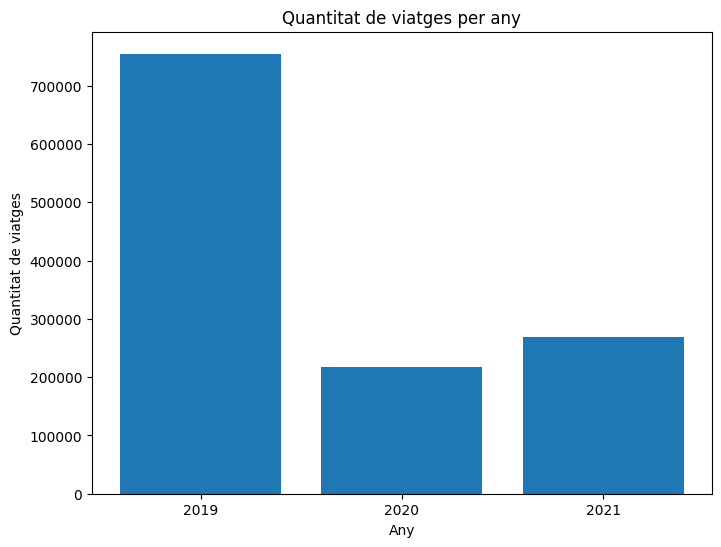

In [14]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i
    la columna que conté la informació
    """

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(YEARS, df[column].value_counts().sort_index().values)
    ax.set_xticks(YEARS)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

bar_plot(df,
         'year',
         'Any',
         'Quantitat de viatges',
         'Quantitat de viatges per any')

+ Visualitza ara en tres gràfiques, el nombre de viatges per mesos de cada any, fent servir la funció anterior.

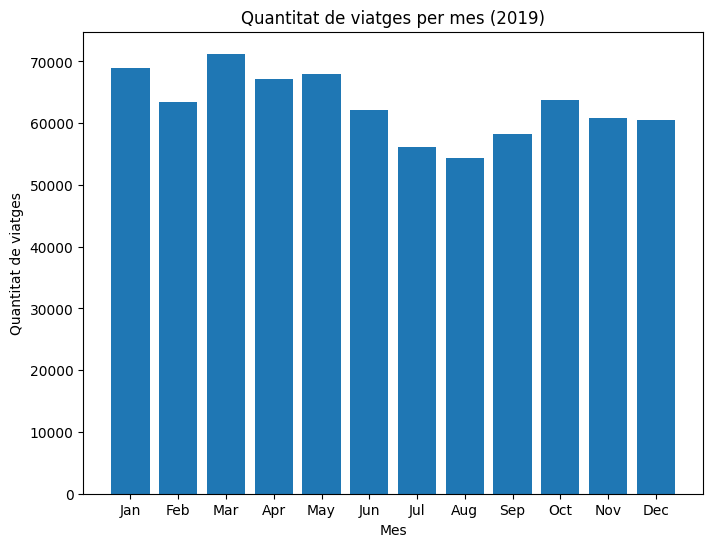

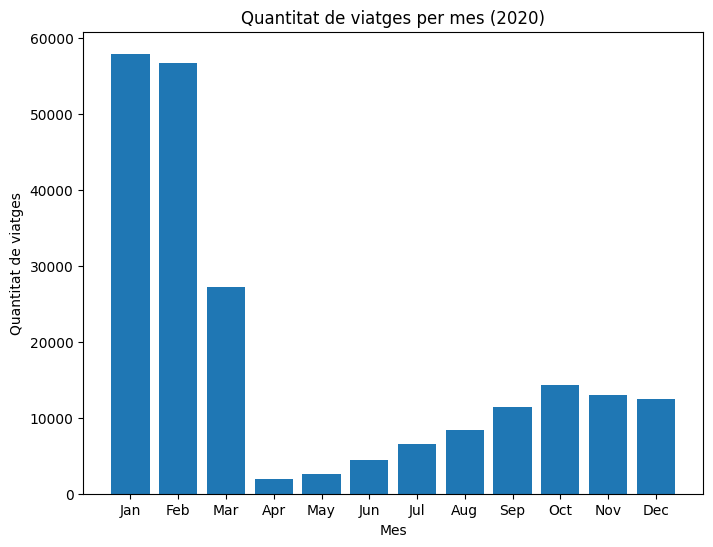

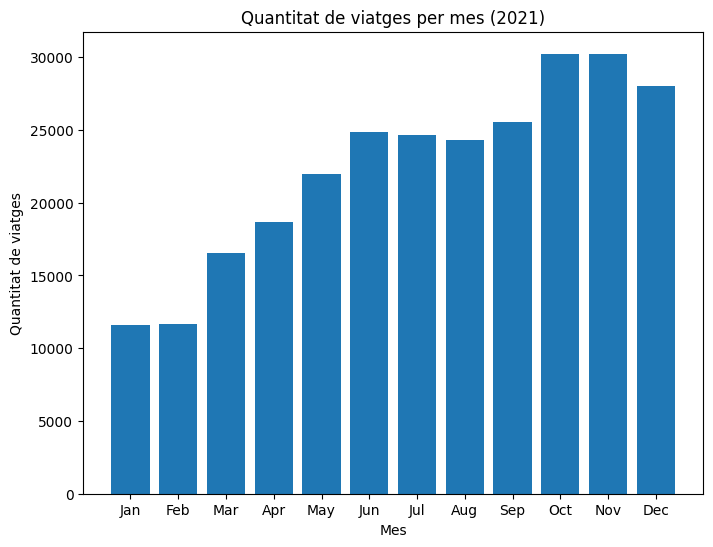

In [15]:
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
def bar_plot(df, column, xlabel, ylabel, title, year):
    """
    Funció que crea una figura de barres a partir del dataframe,
    la columna que conté la informació i l'any
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(1, 13), df[df['year'] == year][column].value_counts().sort_index().values)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(MONTHS)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

for year in YEARS:
    bar_plot(df,
             'month',
             'Mes',
             'Quantitat de viatges',
             f'Quantitat de viatges per mes ({year})',
             year)
    


+ Pregunta:
    + És el comportament que esperàveu? Explica la teva interpretació de les dades tenint en compte el que va passar al món durant aquests anys.

> Resposta

> Sí: Veiem que el nombre de viatges va baixar durant 2020 a partir del març, específicament. Després, el valor es va recuperant a poc a poc, però encara queda lluny d'assolir les xifres del 2019 i la primera part del 2020.

> Per tant, creiem que el covid va tenir una influència clau en la quantitat de viatges de taxi fets a Nova York, reduint extremadament el valor.

+ Visualitza **quants passatgers hi ha per taxi i per any**. Crea una figura **amb tres subfigures** (una per any) on es pugui veure el recompte de passatgers per any.
+ Després repetiu el mateix gràfic visualitzant el % enlloc dels nombres absoluts (utilitzeu el paràmetre *norm = True*).

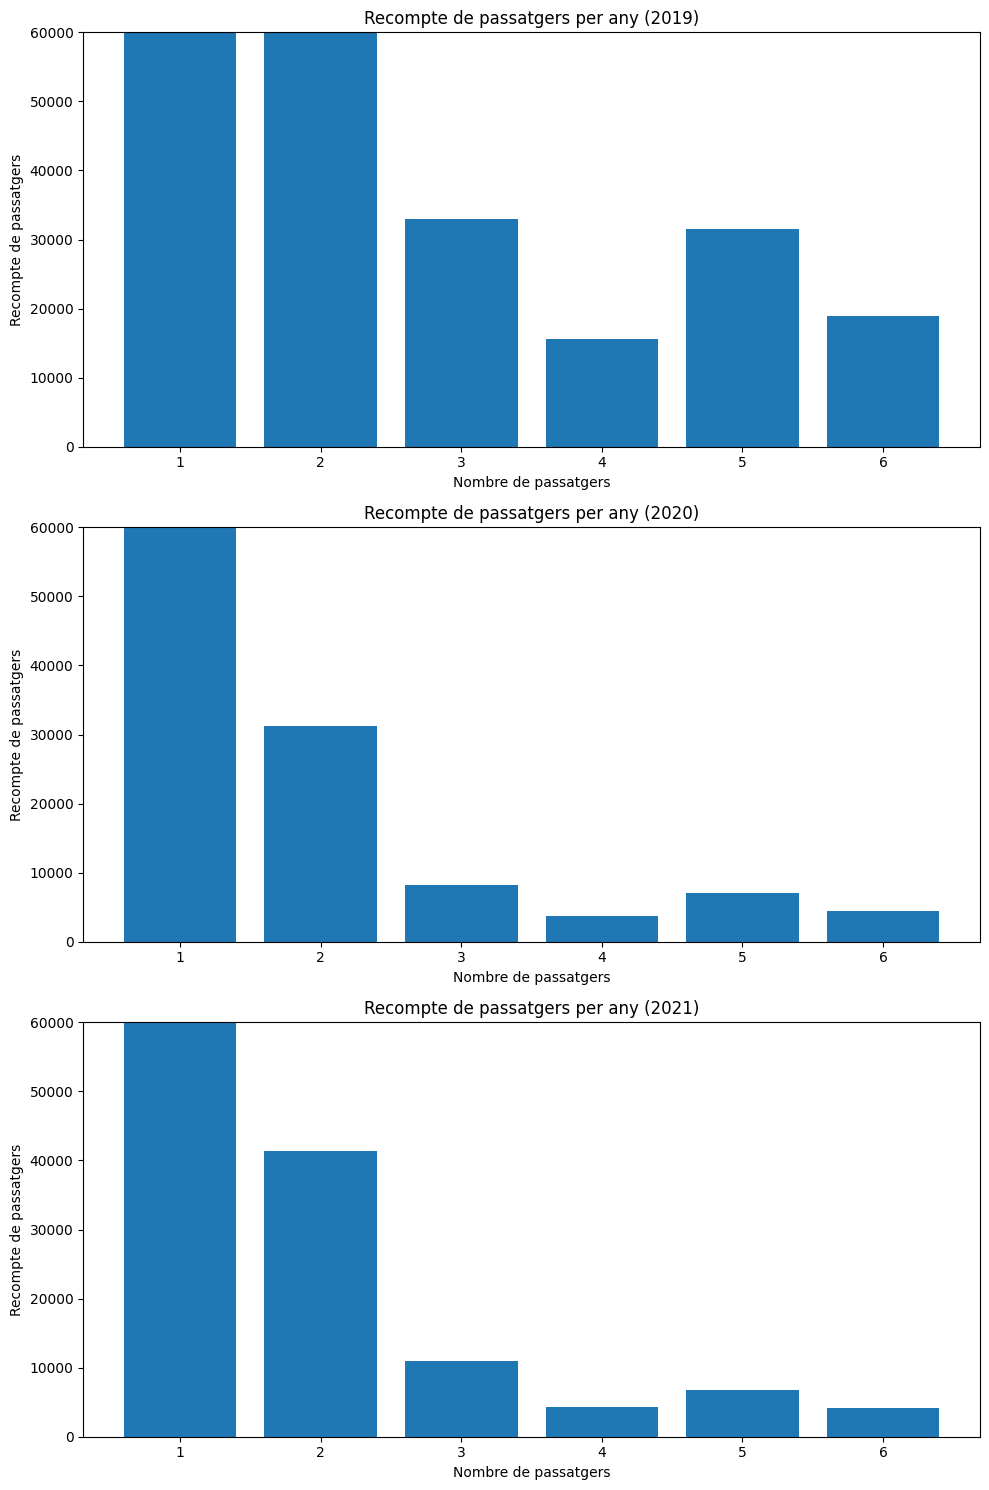

In [16]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    for year in YEARS:
        ax = axs[year-2019]
        if not norm:
            ax.bar(range(1, 7), df[df['year'] == year]['passenger_count'].value_counts().sort_index().values)
            ax.set_xticks(range(1, 7))
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.set_title(f'{title} ({year})')
            ax.set_ylim(ylim)
        else:
            ax.bar(range(1, 7), df[df['year'] == year]['passenger_count'].value_counts(normalize=True).sort_index().values * 100)
            ax.set_xticks(range(1, 7))
            ax.set_xlabel(xlabel)
            ax.set_ylabel('Proporció de viatges')
            ax.set_title(f'{title} normalitzat ({year})')
            ax.set_ylim(0, 100)
    plt.tight_layout()
    plt.show()

    


passengers_taxi_year(df,
                     (0, 60000),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any')

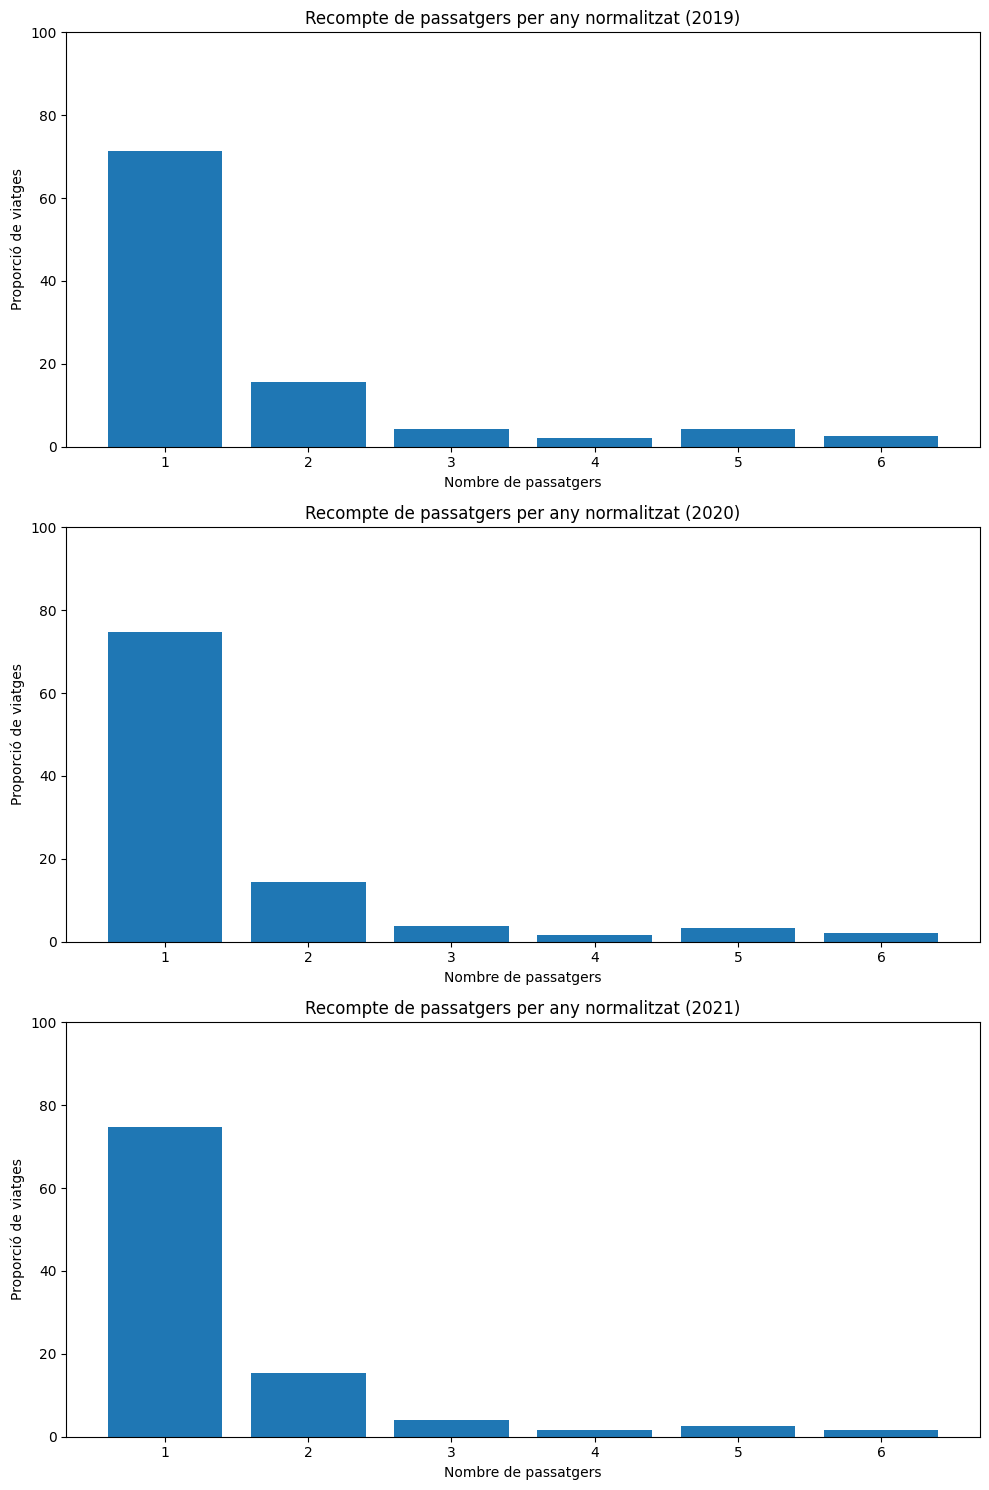

In [17]:
passengers_taxi_year(df,
                     (0, 60000),
                     'Nombre de passatgers',
                     'Recompte de passatgers',
                     'Recompte de passatgers per any',
                     True)


+ Com descriurieu de forma **qualitativa** l'efecte de la covid sobre els taxis en base a l'anàlisi fet fins ara?
+ Podeu calcular de forma **quantitativa** la magnitud dels canvis que heu detectat? Escriviu una funció que calculi una sèrie d'indicadors quantitatius (per exemple, quin canvi percentual hi ha en el nombre de viatges d'una sola persona, la mitja de passatgers per viatge, etc.).

> Respostes
> Fins ara, més enllà de la influència sobre el nombre de viatges, podem inferir quin ha estat l'efecte de la covid sobre la quantitat de passatgers als viatges.

> Quant a les xifres absolutes, podem observar una disminució notòria sobre la quantitat de viatges de més d'una persona. En tots els casos, els viatges individuals superen els 60000.

>  En termes relatius, podem observar que les proporcions han romàs gairebé sense variacions. Només els viatges individuals han augmentat al voltant d'un 3% entre 2019 i 2020, cosa que és consistent amb les mesures preses durant la pandèmia. Tot i això, la variació és lleu i inferim que la disminució ha estat global, és a dir, els viatges individuals també van disminuir en gran mesura. El fet d'haver observat els gràfics relatius han evitat que extraguéssim conclusions incorrectes, podria semblar que no s'hagués donat cap disminució. 

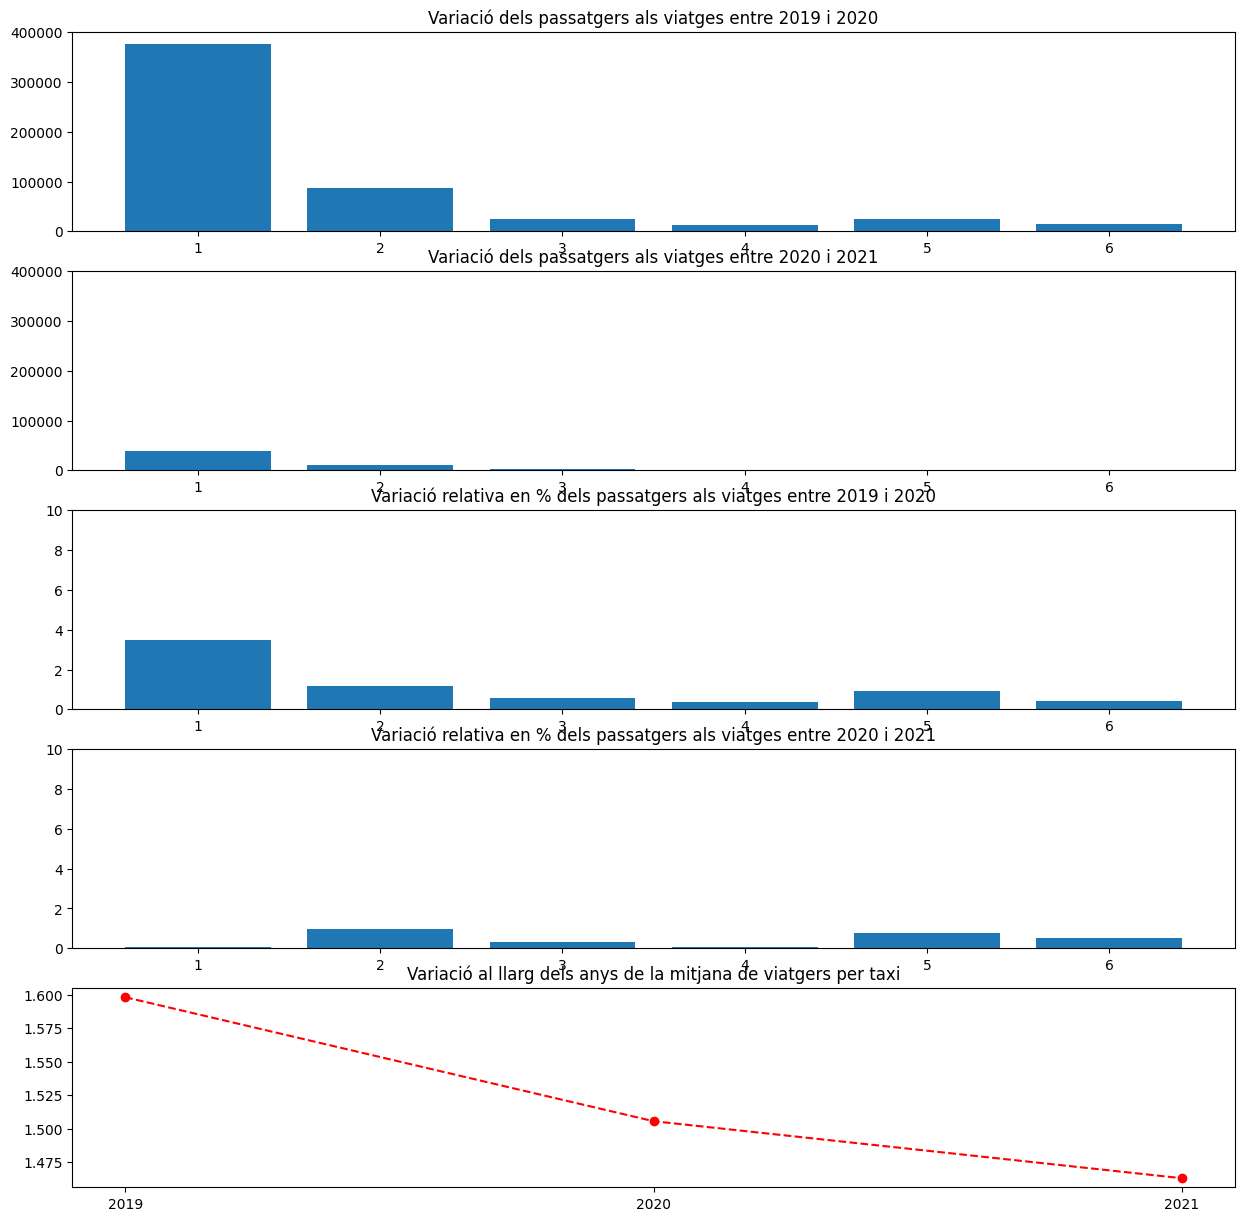

In [18]:
abs_passenger_year_matrix = np.zeros((len(YEARS), 6), dtype=int)
rel_passenger_year_matrix = np.zeros((len(YEARS), 6), dtype=float)
for year in YEARS:
    # Creem una matriu les files de la qual són els anys i les columnes el nombre de passatgers
    abs_passenger_year_matrix[year - 2019] = df[df['year'] == year]['passenger_count'].value_counts().sort_index().values
    rel_passenger_year_matrix[year - 2019] = df[df['year'] == year]['passenger_count'].value_counts(normalize=True).sort_index().values * 100
    
abs_diff_2019_2020 = abs_passenger_year_matrix[1] - abs_passenger_year_matrix[0]
abs_diff_2020_2021 = abs_passenger_year_matrix[2] - abs_passenger_year_matrix[1]
rel_diff_2019_2020 = rel_passenger_year_matrix[1] - rel_passenger_year_matrix[0]
rel_diff_2020_2021 = rel_passenger_year_matrix[2] - rel_passenger_year_matrix[1]
passenger_mean = []
for i in range(0,3):
    vect = abs_passenger_year_matrix[i]
    mean = 0
    for j in range(1,7):
        mean += vect[j-1] * j
    mean /= sum(vect)
    passenger_mean.append(mean)

fig, axs = plt.subplots(5, 1, figsize=(15,15))

axs[0].bar(range(1,7), abs(abs_diff_2019_2020))
axs[0].set_ylim(0,400000)
axs[0].set_title('Variació dels passatgers als viatges entre 2019 i 2020')
axs[1].bar(range(1,7), abs(abs_diff_2020_2021))
axs[1].set_title('Variació dels passatgers als viatges entre 2020 i 2021')
axs[1].set_ylim(0,400000)
axs[2].bar(range(1,7), abs(rel_diff_2019_2020))
axs[2].set_ylim(0,10)
axs[2].set_title('Variació relativa en % dels passatgers als viatges entre 2019 i 2020')
axs[3].bar(range(1,7), abs(rel_diff_2020_2021))
axs[3].set_title('Variació relativa en % dels passatgers als viatges entre 2020 i 2021')
axs[3].set_ylim(0,10)
axs[4].plot(YEARS, passenger_mean, linestyle='--', color='red', marker='o')
axs[4].set_title('Variació al llarg dels anys de la mitjana de viatgers per taxi')
axs[4].set_xticks(YEARS)
plt.show()


> Resposta: A dalt, podem visualitzar les diferències relatives i absolutes dels passatgers respecte als anys consecutius. A més, també podem veure com ha canviat la mitjana de passatgers al llarg dels tres anys.

## 4. Quantitat de viatges per diferents agregacions

Fins ara hem vist la quantitat de viatges que hi ha hagut a nivell de mesos i anys.

Ara podem estudiar l'efecte de la covid en el nombre de trajectes si **agreguem** les dades per hores, dies de la setmana, setmanes de l'any, etc.

### Exercici D

+ Escriu una única funció genèrica que visualitzi el nombre de trajectes per les agregacions de dades comentades i per cada any. Fes servir gràfics de línies discontínues (una línia per cada any) per veure'n l'evolució i marca amb una rodona o creu allà on està el valor.

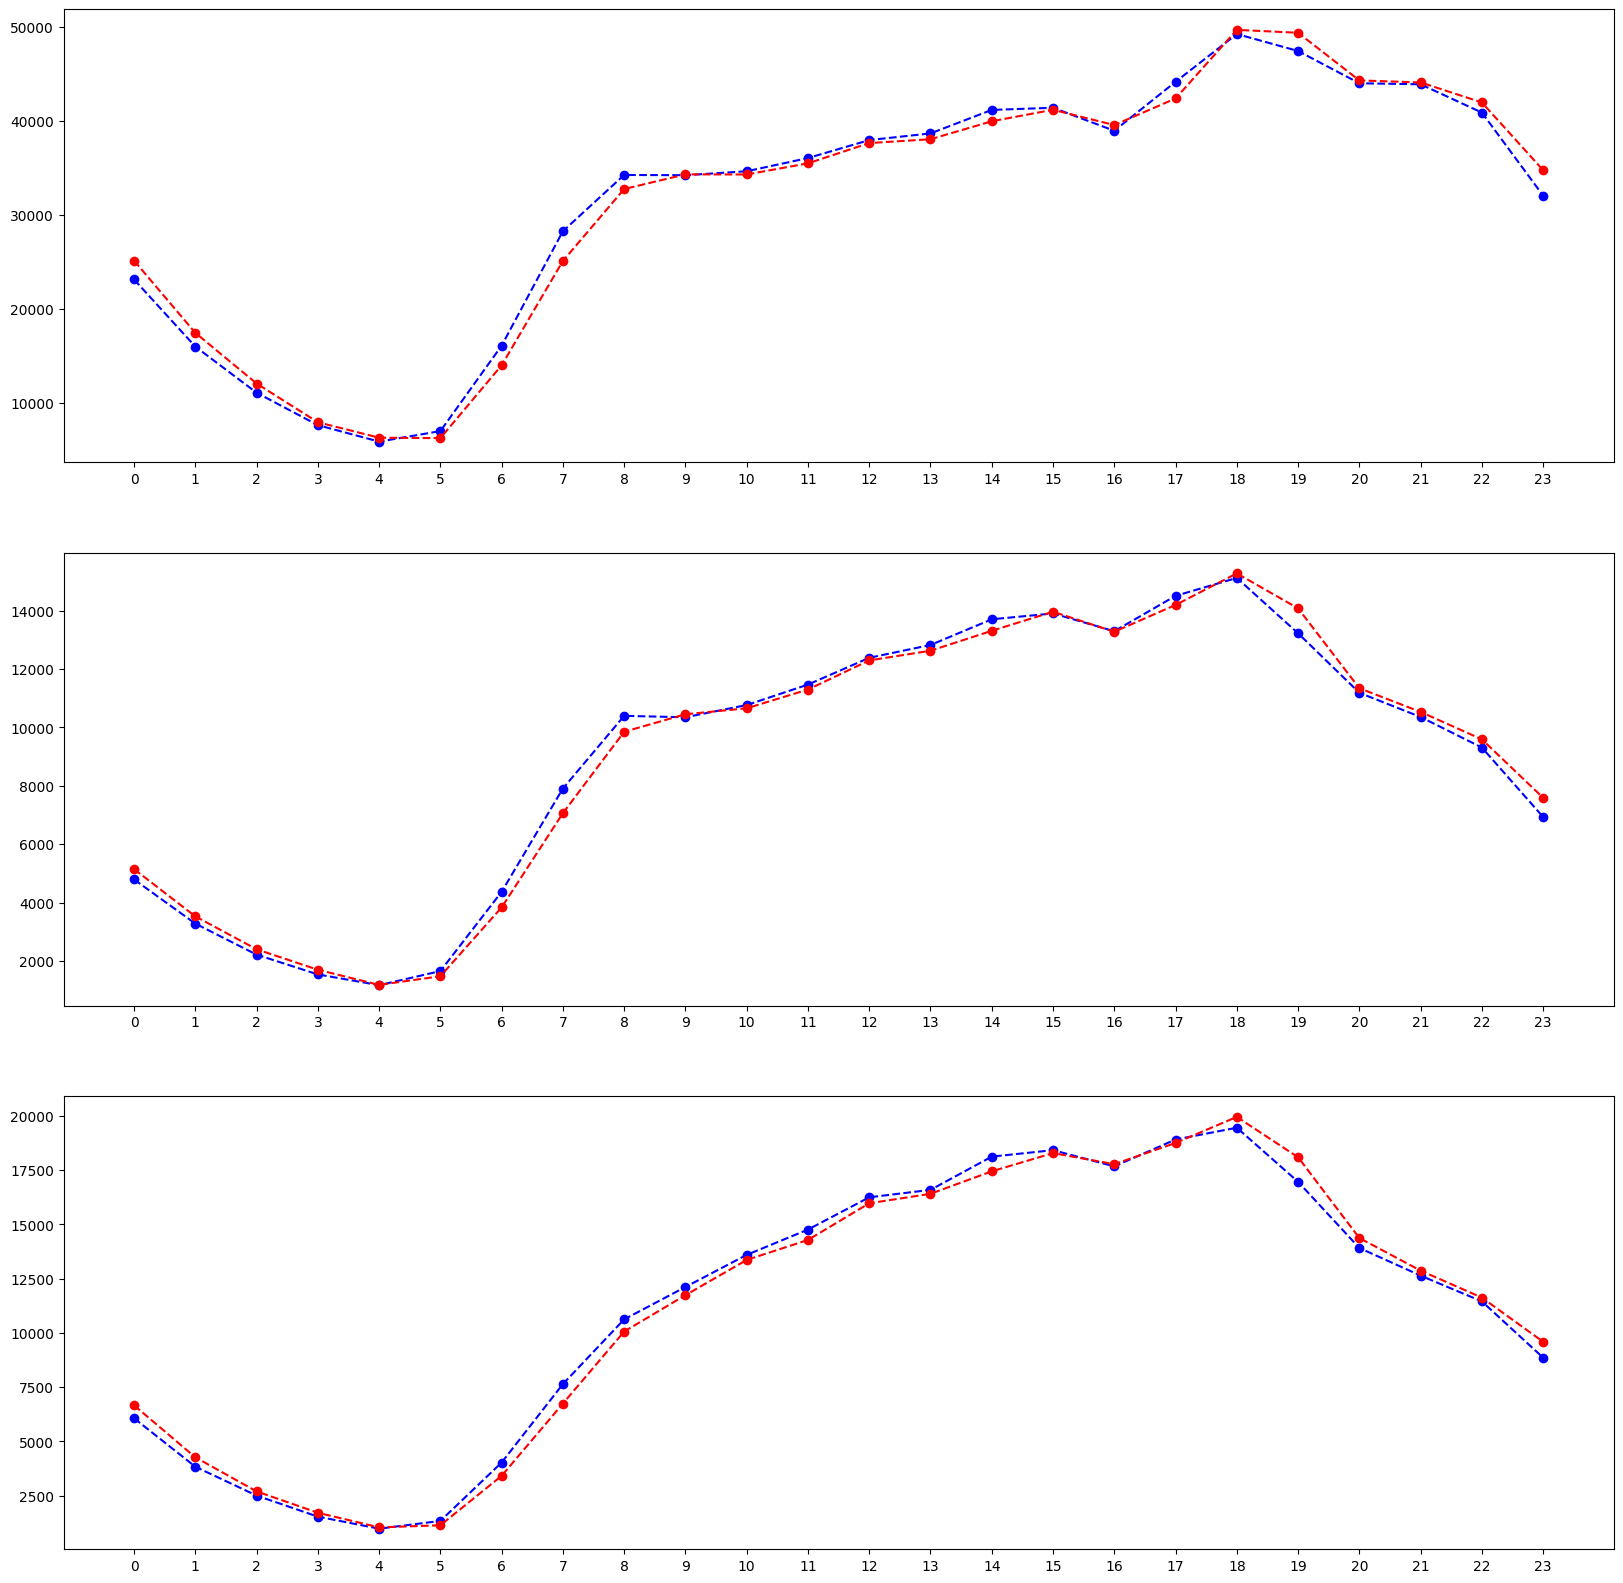

In [19]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    fig, axs = plt.subplots(3, 1, figsize=(20,20))
    for year in YEARS:
        x_values = sorted(df[df['year'] == year][columns[0]].unique())
        ax = axs[year - 2019]
        ax.plot(x_values, df[df['year'] == year][columns[0]].value_counts().sort_index().values, linestyle='--', color='blue', marker='o')
        ax.plot(x_values, df[df['year'] == year][columns[1]].value_counts().sort_index().values, linestyle='--', color='red', marker='o')
        ax.set_xticks(x_values)
    plt.show()


visualize_trips(df,
                ['pickup_hour', 'dropoff_hour'],
                title = 'Quantitat de viatges per hora',
                xlabel = 'Hora del dia', ylabel = 'Quantitat')

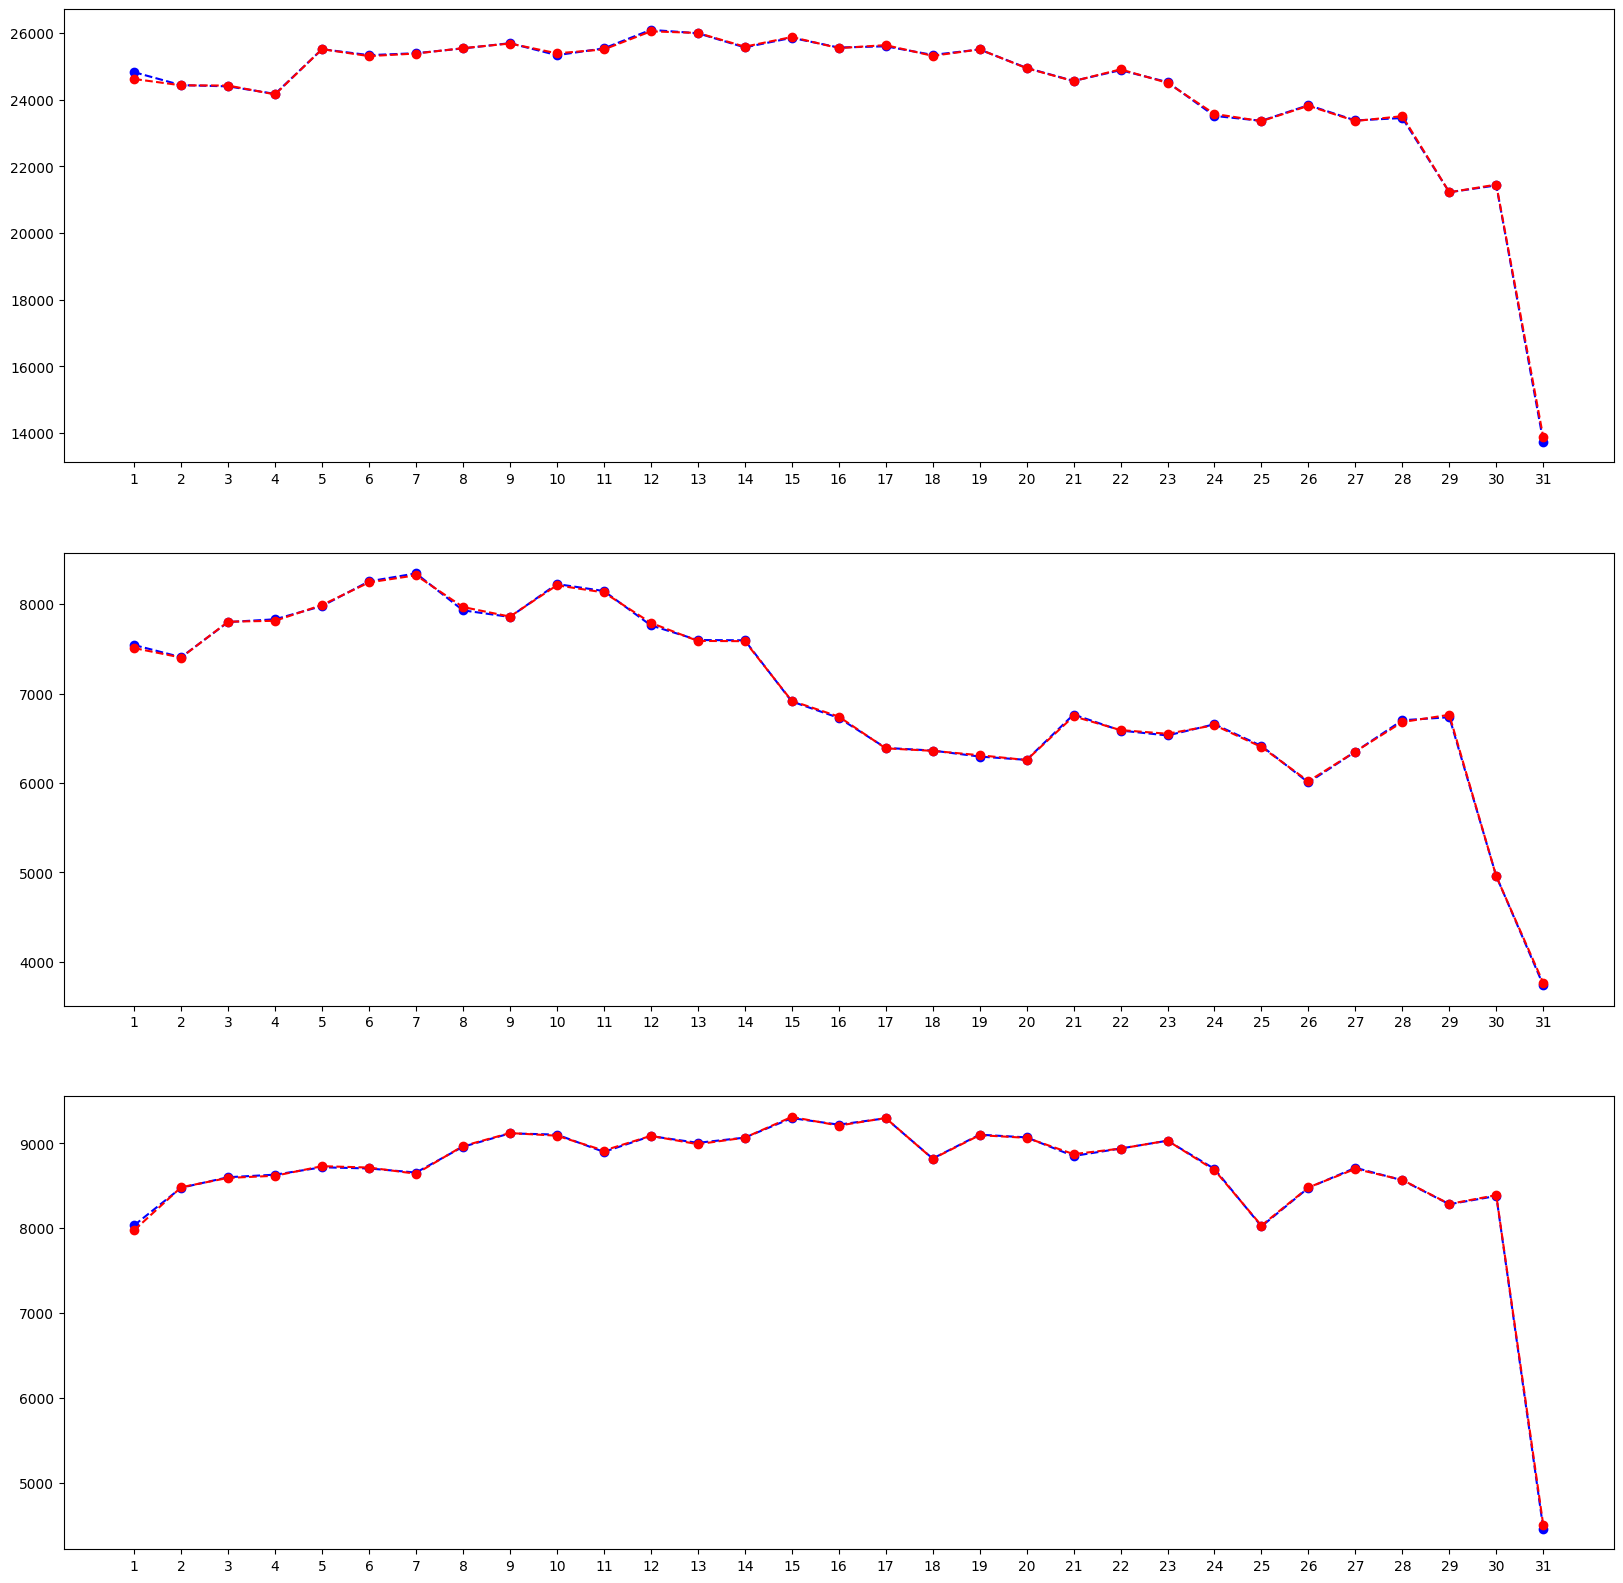

In [20]:
visualize_trips(df,
                ['pickup_day', 'dropoff_day'],
                title = 'Quantitat de viatges per dia de la setmana',
                xlabel = 'Dia de la setmana',
                ylabel = 'Quantitat')

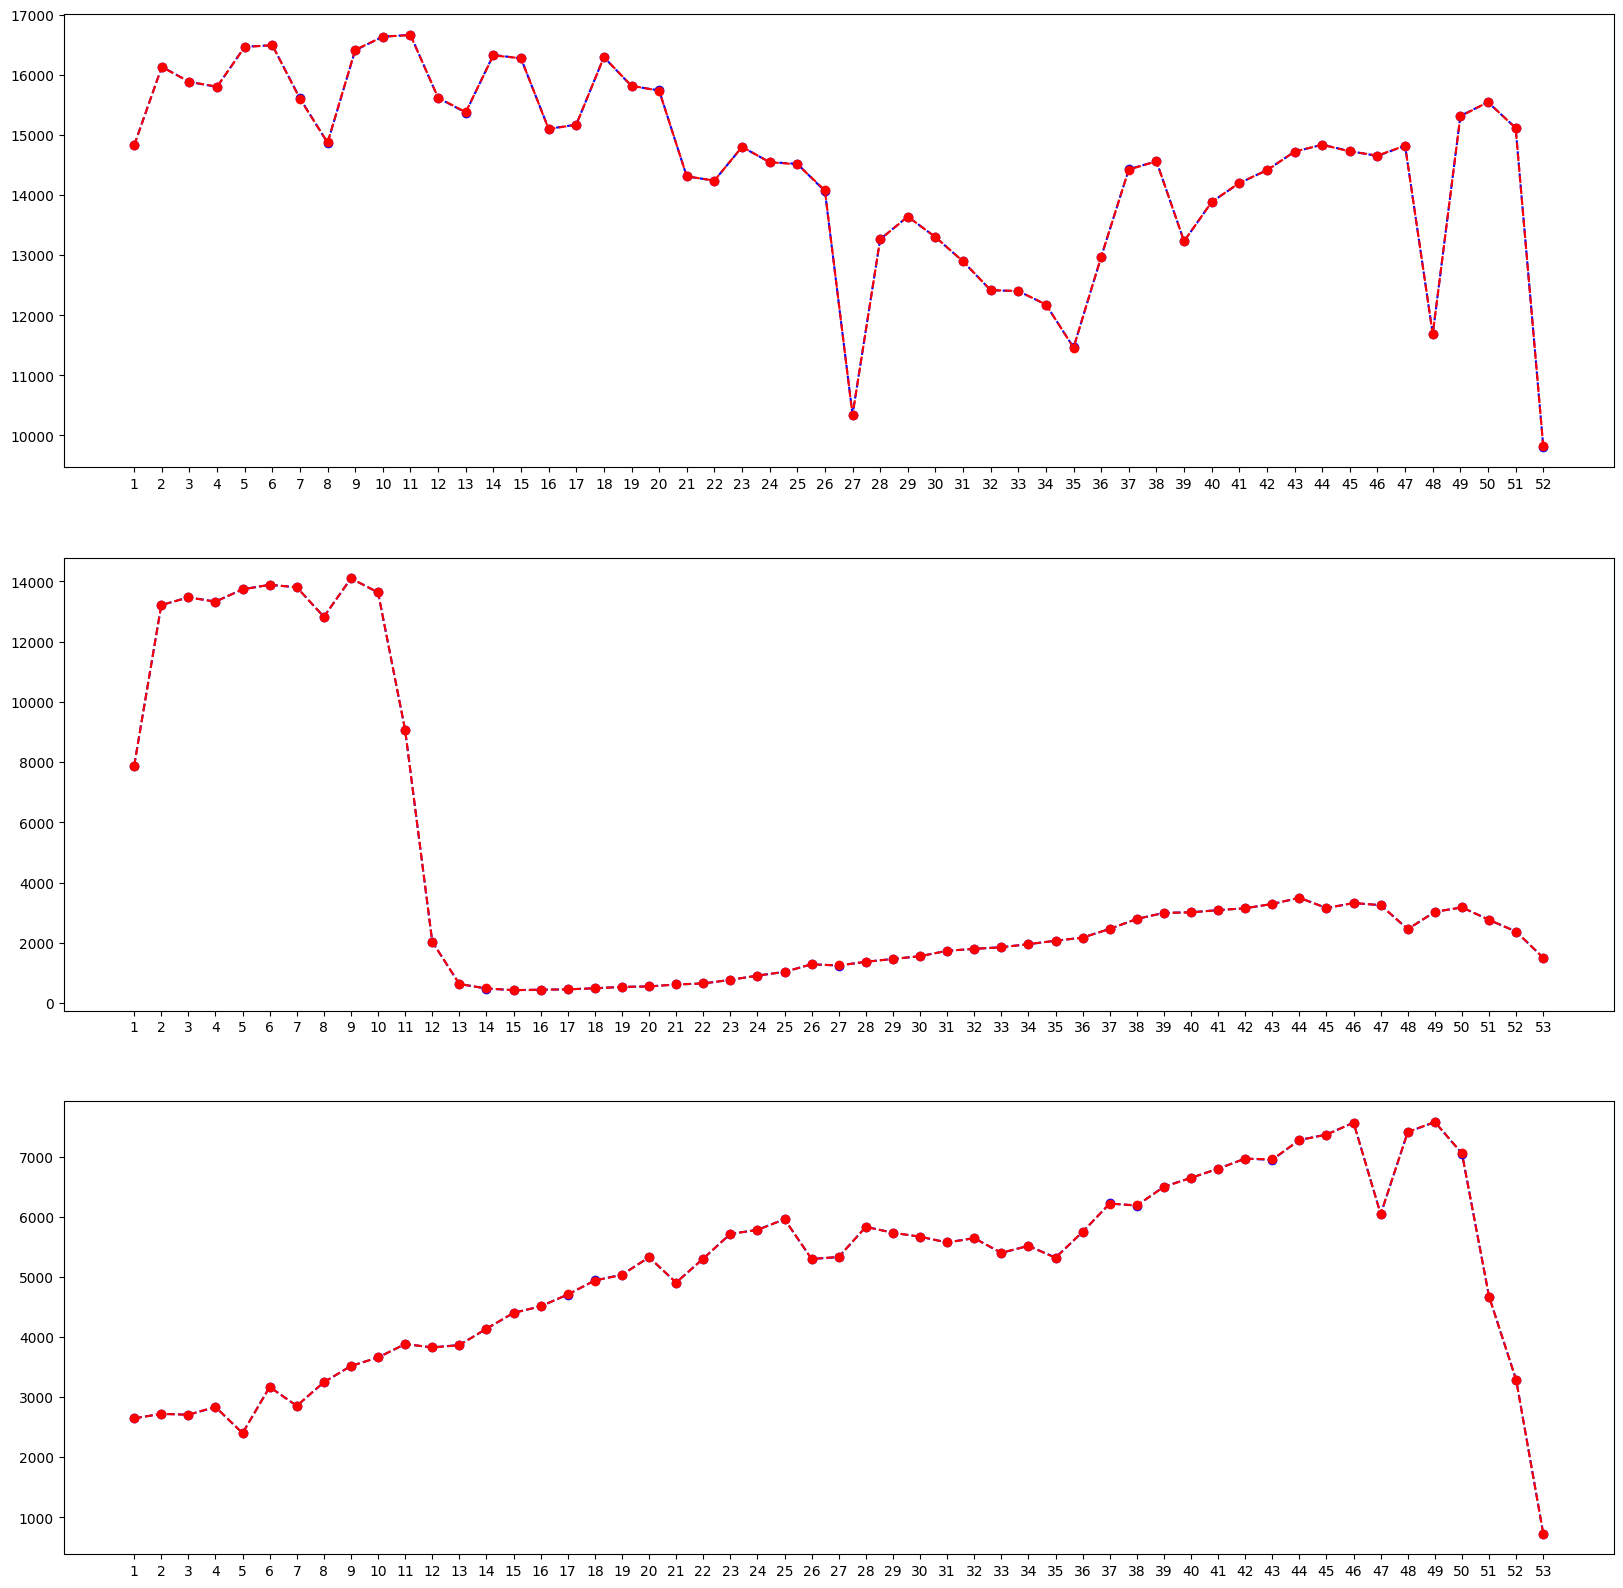

In [21]:
visualize_trips(df,
                ['pickup_week', 'dropoff_week'],
                title = 'Quantitat de viatges per setmana de l\'any',
                xlabel = 'Setmana de l\'any',
                ylabel = 'Quanitat')

+ Com descriurieu l'efecte de la covid en cada cas (si és que en té)? Quin creieu que és el motiu?

> Resposta:

> 1. Per hores: no veiem, gairebé, influència de la covid, de fet les gràfiques són pràcticament idèntiques. Això té sentit, una pandèmia no té perquè influir sobre les hores del dia a les quals es fan viatges en taxi a menys que hi hagi restriccions horàries. De fet, l'única diferència visible és que per la nit, a partir del 2020, van disminuir els viatges després de les 20:00... Segons diverses fonts, això pot ser consistent amb el fet que van imposar-se diferents restriccions, menys dràstiques que un toc de queda, que sí afectaren al comerços, etc. I sí va haver-hi un toc de queda durant la primera setmana de juny del 2020 a causa de l'assassinat de George Floyd.

> 2. Per dies: L'impacte que veiem és més subtil. Veiem que el 2020 hi ha un descens clar a partir del dia 14, i les mesures com els confinaments van començar a prendre's, més o menys, a partir d'aquest mateix dia en març. Per tant, el descens s'explica pel fet que hi ha pocs mesos en els quals no s'haguessin pres mesures durant la segona setmana. La informació dels darrers dies del mes no és comparable amb la resta, ja que no tots els mesos tenen la mateixa quantitat de dies. 

> 3. Per setmanes: L'impacte de la COVID és evident. Veiem com hi ha una dràstica caiguda del ritme habitual a partir de la setmana 10 de 2020, que va recuperant-se paulatinament. Els pics que es donen cap avall, poden ser conseqüència de festivitats o esdeveniments que impedeixin la circulació habitual. A més, l'última setmana no aporta una informació comparable amb la resta, ja que pot contenir molts menys dies.

## 5. Relació distancia, temps i velocitat

A les dades tenim la **distància** que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la **durada** d'aquest.

Ara explorarem com la covid va afectar les distàncies i les durades dels viatges, i també la velocitat dels taxis. També ens preguntarem si la densitat de trànsit va variar.

### Exercici E

+ Per començar, escriu una funció que visualitzi els **histogrames** de distància i durada per any.

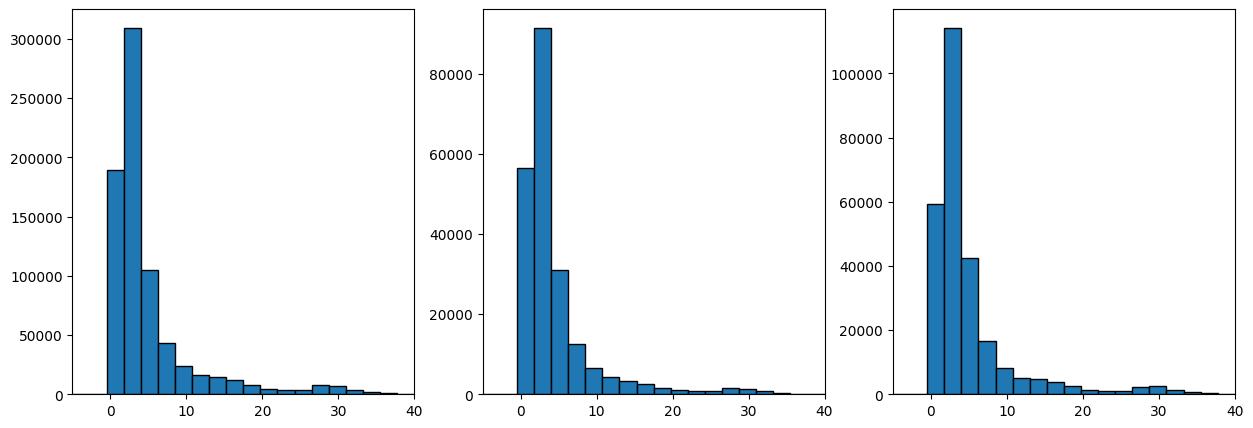

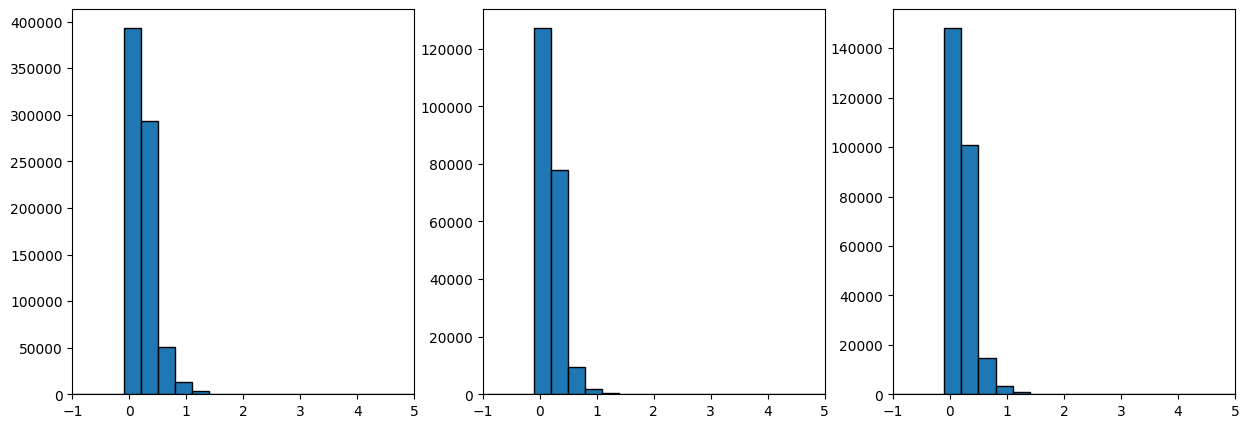

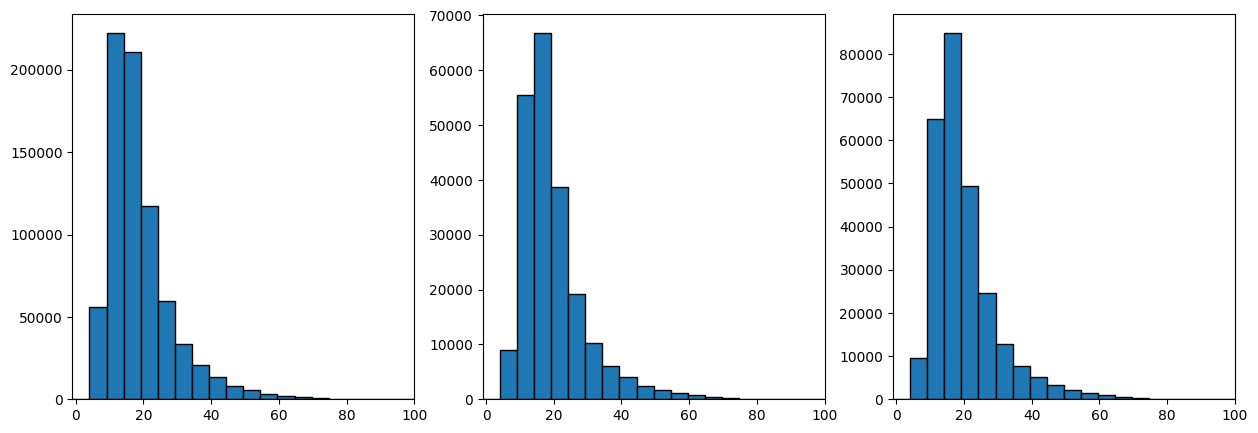

In [22]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """
    data = []
    for year in YEARS:
        data_year = df[df['year'] == year][column].values
        data.append(data_year / 3600 if column == 'trip_duration' else data_year)

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(3):
        bins = np.linspace(xlim[0], xlim[1], 21)  # 21 bordes = 20 bins
        axs[i].hist(data[i], bins=bins, edgecolor='black')
        axs[i].set_xlim(xlim)
    plt.show()
    

visualize_histograms(df, 'trip_distance', title = 'Distància dels viatge per any',
                     xlabel = 'Distància (km)', ylabel = 'Quantitat', xlim = (-5, 40))

visualize_histograms(df, 'trip_duration', title = 'Durada dels viatges per any',
                     xlabel = 'Durada (h)', ylabel = 'Quantitat', xlim = (-1, 5) )

visualize_histograms(df, 'average_speed_kmh', title = 'Velocitat dels viatge per any',
                     xlabel = 'Velocitat (Km/h)', ylabel = 'Quanitat', xlim = (-1, 100) )

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> Resposta:

> 1. Quant a la distància, observem que, en termes relatius, les quantitats no han variat. Més aviat, s'ha produït un descens absolut global de 2019 a 2020 que es recupera poc a poc entre 2020 i 2021.

> 2. Quant a la durada dels viatges, observem que sí s'ha produït un descens relatiu: es van començar a prendre menys viatges llargs en 2020, predominant els més curts; això va recuperar-se poc a poc. Això va anar acompanyat, també, d'un descens absolut global que va recuperar-se poc a poc.

> 3. Quant a la velocitat mitjana, és interessant veure com hi ha menys viatges extremadament lents, cosa que és més que probable que es degui al fet que el tràfic va disminuir en gran mesura. La resta de velocitats mitjanes semblen seguir una distribució molt similar, que no ens permet extreure conclusions significatives.


+ velocitat mitja per hora

In [23]:
hourly_mean_speed = df.groupby('pickup_hour')['average_speed_kmh'].mean()

print(hourly_mean_speed)

pickup_hour
0     24.691483
1     24.919020
2     25.337391
3     26.620211
4     30.755199
5     32.387154
6     26.327564
7     21.051493
8     18.039591
9     17.845259
10    17.915424
11    17.343746
12    17.266621
13    17.377954
14    16.789011
15    16.445951
16    16.707815
17    16.644049
18    17.222286
19    18.624485
20    20.251307
21    21.127214
22    21.858343
23    23.158714
Name: average_speed_kmh, dtype: float32


In [24]:
hourly_weekday_mean_speed = df.groupby(['pickup_hour', 'pickup_day'])['average_speed_kmh'].mean()

print(hourly_weekday_mean_speed[2])


pickup_day
1     24.286530
2     25.117439
3     25.970423
4     26.667593
5     24.759071
6     25.858843
7     25.338200
8     24.770447
9     24.710352
10    25.971478
11    25.792723
12    25.413752
13    24.600744
14    24.871254
15    25.687891
16    24.872591
17    25.297899
18    26.762249
19    25.767599
20    25.314583
21    25.751144
22    25.955328
23    25.798037
24    24.571955
25    25.317410
26    25.272121
27    25.488485
28    25.253679
29    24.567957
30    25.696463
31    25.191099
Name: average_speed_kmh, dtype: float32


Pregunta:

+ Escriu una funció que identifiqui les cinc ubicacions de recollida (PULocationID) més freqüents.
+ Per a aquestes cinc ubicacions de recollida, calcula el nombre mitjà de passatgers (passenger_count) per trajecte.
+ Filtra els trajectes on la ubicació de recollida i de deixada són la mateixa (PULocationID == DOLocationID). Calcula el percentatge d'aquests trajectes respecte al total de trajectes.

In [25]:
def analyze_pickup_dropoff_locations(df):
    top_pickup_locations = df['PULocationID'].value_counts().head(5).index.tolist()
    average_passengers = {location: float(df[df['PULocationID'] == location]['passenger_count'].mean()) for location in top_pickup_locations}
    percentage_same_location_trips = len(df[df['DOLocationID'] == df['PULocationID']]) * 100 / len(df)
    return {
        'top_pickup_locations': top_pickup_locations,
        'average_passengers': average_passengers,
        'percentage_same_location_trips': percentage_same_location_trips
    }

analyze_pickup_dropoff_locations(df)

{'top_pickup_locations': [237, 236, 161, 162, 186],
 'average_passengers': {237: 1.5168570926349094,
  236: 1.524331200516433,
  161: 1.5489278913817368,
  162: 1.531367701088338,
  186: 1.5186457197224608},
 'percentage_same_location_trips': 3.7645489180017377}